# Performing GMM
Now that we have our dataset, we can now perform GMM to cluster stocks based on the technical indicators.

In [43]:
tickers = ["AMZN", "TSLA", "BABA", "HD", "TM", "NKE", "MCD", "LOW", "SBUX", "JD", "PDD", "BKNG", "GM", "MELI", "TJX", "NIO", "F", "LULU", "HMC", "CMG"]

In [44]:
import sys
import os

!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas

In [45]:
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
import sklearn.metrics as metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from IPython.display import display, HTML

%matplotlib inline


We will first perform GMM on each stock individually based on its technical indicators, with the covariance type as full

Clustering stocks using GMM


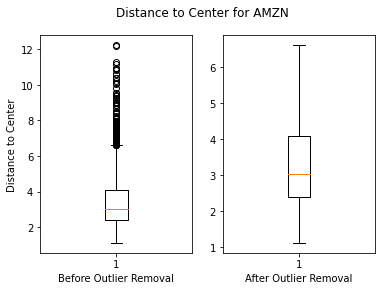

AMZN has 313 outliers out of 2417 points (12.95%)


,RSI,Ultimate,BandRadius,Chaikin,NATR,SMA_5,SMA_20,SMA_100,SAR,Williams%R,APO,ROC_5,ROC_20,ROC_100,ClusterCoverage%
0,60.621462,56.233392,0.024723,1.118809e+06,2.295297,0.993908,0.974968,0.907394,0.441964,-28.910796,0.016755,0.015680,0.056459,0.217079,0.327947
1,62.458631,59.048691,0.019971,1.690601e+06,1.857883,0.991455,0.969421,0.927639,0.084963,-20.667214,0.014564,0.021439,0.054598,0.152890,0.259506
2,42.763210,44.009610,0.026223,-1.267492e+06,2.613972,1.008452,1.026944,0.995900,0.510809,-73.111113,-0.008367,-0.018873,-0.033346,0.076930,0.111692
3,51.497931,56.266920,0.025718,1.589034e+06,2.342277,0.989197,0.993546,1.020031,0.351865,-33.665913,-0.014727,0.022973,-0.017177,-0.025447,0.069392
4,51.055236,49.176788,0.020174,-4.027164e+05,2.044689,1.005038,1.005494,0.963805,0.123668,-54.864294,0.004638,-0.009416,0.005774,0.114376,0.231464


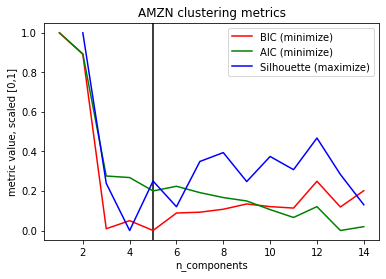

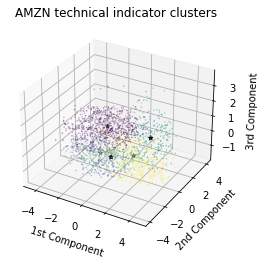

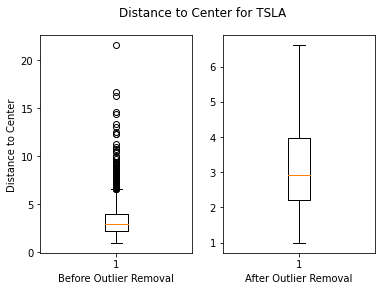

TSLA has 336 outliers out of 2417 points (13.9%)


,RSI,Ultimate,BandRadius,Chaikin,NATR,SMA_5,SMA_20,SMA_100,SAR,Williams%R,APO,ROC_5,ROC_20,ROC_100,ClusterCoverage%
0,41.485516,43.985031,0.042089,-7.778667e+06,4.156710,1.018338,1.053437,1.043292,0.094967,-73.741421,-0.017752,-0.040158,-0.068774,0.074111,0.260932
1,54.492745,55.250832,0.040614,1.092593e+07,3.784437,0.988505,0.980425,0.983267,0.081469,-34.561374,-0.003990,0.029254,0.022669,0.106615,0.358962
2,67.145386,61.063140,0.039806,1.891829e+07,3.664051,0.975674,0.918884,0.839303,0.074506,-10.357816,0.037087,0.062095,0.155676,0.448602,0.153772
3,54.620222,48.866659,0.044066,-5.291125e+06,4.083556,0.992024,0.977947,0.971712,0.668128,-44.586588,0.011054,0.019075,0.050563,0.045791,0.120135
4,57.158667,49.637672,0.041205,-8.498355e+05,4.080323,1.007763,0.980427,0.836598,0.072471,-48.135273,0.041999,-0.010796,0.110008,0.603346,0.106199


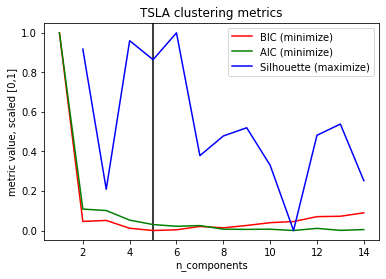

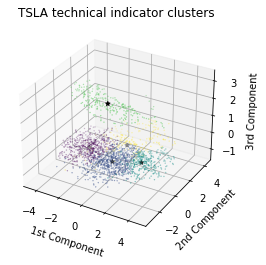

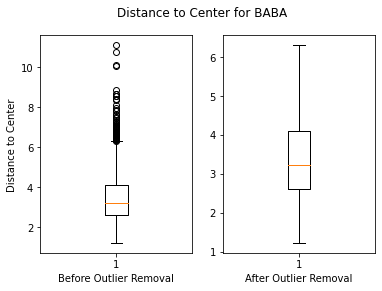

BABA has 244 outliers out of 1700 points (14.35%)


,RSI,Ultimate,BandRadius,Chaikin,NATR,SMA_5,SMA_20,SMA_100,SAR,Williams%R,APO,ROC_5,ROC_20,ROC_100,ClusterCoverage%
0,40.346124,41.528462,0.027795,-7.683562e+06,2.814232,1.014444,1.037985,1.063380,0.871613,-75.800388,-0.013824,-0.030660,-0.052971,-0.049962,0.157280
1,49.908937,48.714178,0.030569,-3.245831e+05,2.764908,1.008430,1.010182,0.962226,0.363727,-56.388313,0.004845,-0.015799,0.003375,0.140526,0.163462
2,44.363225,48.753001,0.039562,-1.093094e+06,3.442936,0.995925,1.014361,1.085773,0.419162,-52.139124,-0.025189,0.008701,-0.047514,-0.090478,0.136676
3,60.303829,58.497257,0.032371,7.535750e+06,2.880272,0.984681,0.963777,0.957152,0.472630,-18.768975,0.008731,0.035437,0.054215,0.093121,0.138049
4,58.062795,53.528584,0.019485,1.939929e+06,2.297953,0.992365,0.972851,0.977820,1.272980,-29.512110,0.014622,0.018598,0.054037,0.015969,0.219780


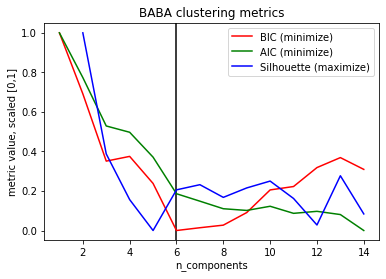

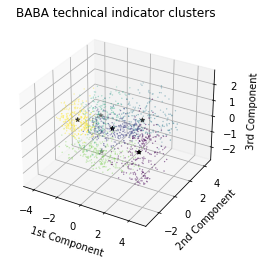

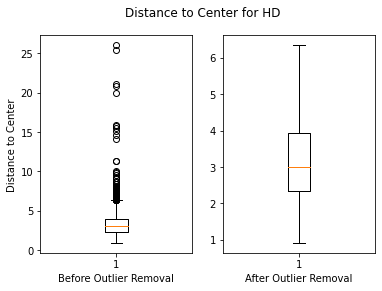

HD has 302 outliers out of 2417 points (12.49%)


,RSI,Ultimate,BandRadius,Chaikin,NATR,SMA_5,SMA_20,SMA_100,SAR,Williams%R,APO,ROC_5,ROC_20,ROC_100,ClusterCoverage%
0,56.648614,-0.295486,0.015545,-5.272208e+08,18.837078,0.998578,0.990930,0.950359,0.512840,-323.714256,0.007813,0.004374,0.023055,0.114976,0.400000
1,63.694524,5.964683,0.018237,-1.849665e+08,8.966006,0.991545,0.973365,0.934231,0.231152,-134.077874,0.013179,0.019977,0.049078,0.123188,0.331442
2,47.181847,1.483417,0.017629,-1.846578e+08,9.487786,1.004144,1.010632,0.987103,0.241085,-200.094333,-0.002965,-0.008697,-0.013227,0.063218,0.268558


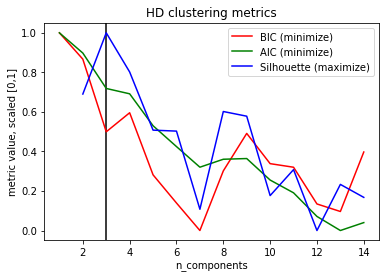

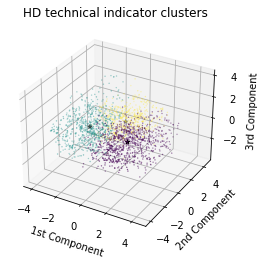

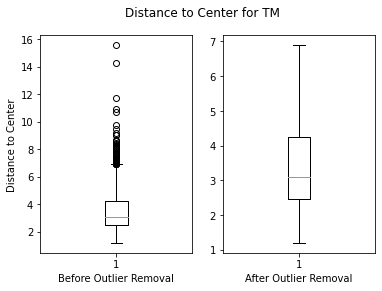

TM has 300 outliers out of 2417 points (12.41%)


,RSI,Ultimate,BandRadius,Chaikin,NATR,SMA_5,SMA_20,SMA_100,SAR,Williams%R,APO,ROC_5,ROC_20,ROC_100,ClusterCoverage%
0,62.932134,55.838137,0.017304,4.604026e+05,1.036342,0.987321,0.972532,0.961974,0.458894,-3.705868,0.005648,0.027978,0.036137,0.054231,0.089750
1,43.998294,-16.792433,0.018997,-2.818962e+07,10.571619,1.002780,1.012000,1.017975,0.635540,-235.281819,-0.005944,-0.006987,-0.018987,0.004589,0.074162
2,50.014433,45.543128,0.015387,-1.630854e+05,1.334602,1.004791,1.004446,0.983855,0.457601,-59.931894,0.003859,-0.009060,0.003765,0.049696,0.124232
3,49.506830,46.704538,0.017227,5.842319e+05,1.131885,0.999746,1.002786,1.004875,0.469088,-47.273081,-0.002966,0.000509,-0.005916,0.004787,0.098725
4,49.327455,-2.796311,0.018459,-2.323789e+07,8.897890,0.998963,1.000938,0.999106,0.601263,-189.819547,-0.001740,0.001807,-0.001935,0.026509,0.057629


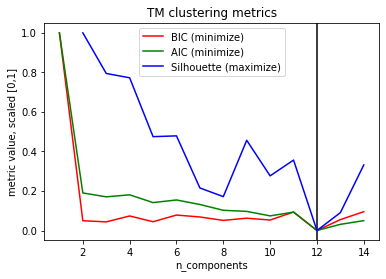

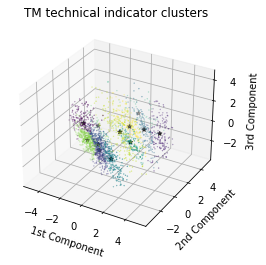

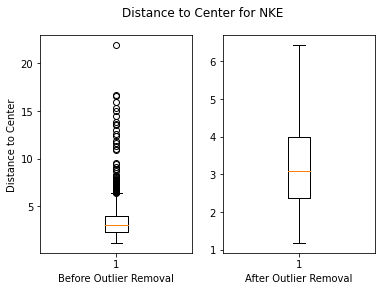

NKE has 300 outliers out of 2417 points (12.41%)


,RSI,Ultimate,BandRadius,Chaikin,NATR,SMA_5,SMA_20,SMA_100,SAR,Williams%R,APO,ROC_5,ROC_20,ROC_100,ClusterCoverage%
0,60.792479,14.652179,0.021461,-9.371008e+07,4.146372,0.992268,0.976585,0.936534,0.266658,-61.199610,0.011312,0.018296,0.042817,0.127255,0.321682
1,59.059450,0.166308,0.016653,-2.889374e+08,9.106948,0.997237,0.983463,0.938228,0.658937,-164.756438,0.012820,0.008118,0.038833,0.128437,0.343410
2,44.256420,3.797684,0.020953,-1.628840e+08,5.763550,1.004903,1.016769,1.006556,0.385370,-131.528955,-0.007516,-0.011185,-0.025704,0.035001,0.334908


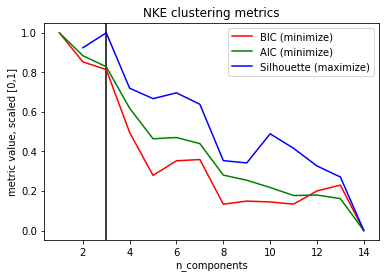

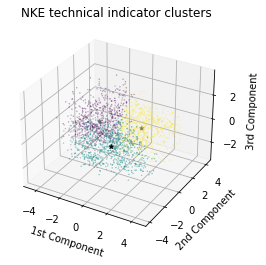

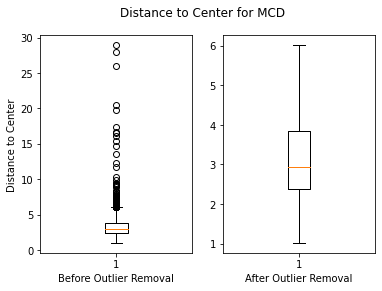

MCD has 306 outliers out of 2417 points (12.66%)


,RSI,Ultimate,BandRadius,Chaikin,NATR,SMA_5,SMA_20,SMA_100,SAR,Williams%R,APO,ROC_5,ROC_20,ROC_100,ClusterCoverage%
0,56.381343,2.554305,0.013886,-2.204749e+08,9.864586,0.999008,0.993260,0.962016,0.594145,-211.619227,0.005756,0.003175,0.016576,0.085608,0.107058
1,46.220880,-1.857806,0.012769,-8.619377e+08,28.723317,0.998756,1.004401,1.035294,1.308860,-579.575858,-0.006401,0.001794,-0.013289,-0.064283,0.039318
2,49.211336,3.227911,0.016178,3.842651e+06,3.206378,0.999815,1.002820,0.994644,0.365085,-72.879034,-0.002282,0.000370,-0.005487,0.033253,0.090005
3,43.997034,0.412749,0.015133,-4.033517e+08,15.200364,1.000192,1.008843,1.031428,0.813923,-311.452950,-0.008017,-0.001358,-0.020298,-0.042079,0.053529
4,64.446934,2.583574,0.012019,-3.929080e+08,14.952296,0.996377,0.981220,0.932026,0.772530,-309.272108,0.013180,0.009765,0.040085,0.127814,0.105163


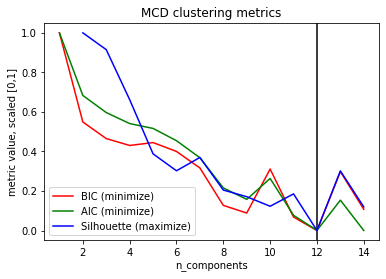

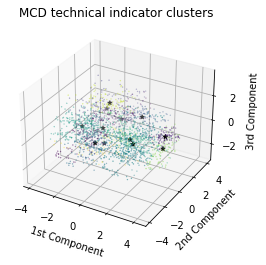

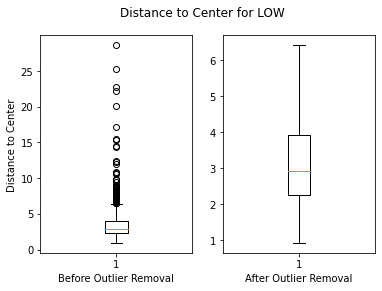

LOW has 305 outliers out of 2417 points (12.62%)


,RSI,Ultimate,BandRadius,Chaikin,NATR,SMA_5,SMA_20,SMA_100,SAR,Williams%R,APO,ROC_5,ROC_20,ROC_100,ClusterCoverage%
0,59.482656,8.796491,0.020812,-8.935096e+07,5.981560,0.994344,0.978640,0.939293,0.201056,-88.620137,0.012021,0.014383,0.043368,0.119288,0.355587
1,59.654722,0.716248,0.018881,-3.737601e+08,14.462805,0.997186,0.981305,0.926249,0.511600,-221.434867,0.015426,0.008447,0.046475,0.154977,0.331913
2,44.904254,-0.486141,0.021132,-2.229277e+08,10.700674,1.003759,1.016749,1.014145,0.362910,-194.653488,-0.009448,-0.008857,-0.028311,0.028085,0.312500


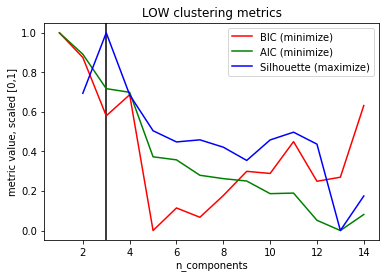

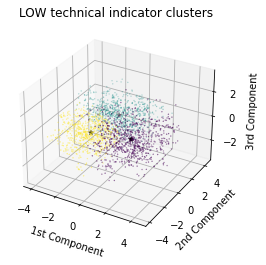

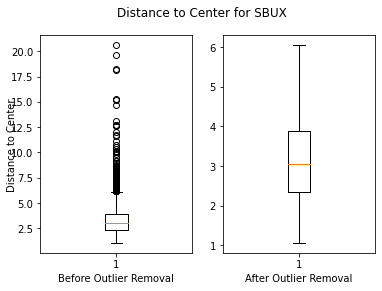

SBUX has 356 outliers out of 2417 points (14.73%)


,RSI,Ultimate,BandRadius,Chaikin,NATR,SMA_5,SMA_20,SMA_100,SAR,Williams%R,APO,ROC_5,ROC_20,ROC_100,ClusterCoverage%
0,58.643204,7.607223,0.018042,-1.825962e+08,6.046935,0.996295,0.985023,0.941835,0.282778,-101.726160,0.009614,0.009573,0.031663,0.127948,0.331393
1,46.889886,0.214600,0.018112,-4.087984e+08,11.014807,1.001176,1.007968,1.010404,0.470757,-207.305132,-0.005391,-0.002990,-0.014717,0.001487,0.402717
2,60.691210,0.661363,0.016988,-5.424469e+08,14.337151,0.997273,0.981137,0.926021,0.606167,-235.715118,0.015506,0.008157,0.045509,0.160259,0.265890


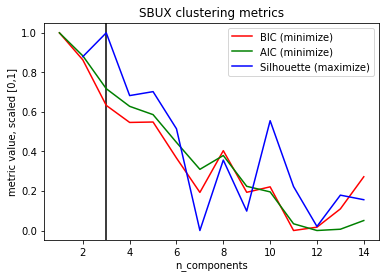

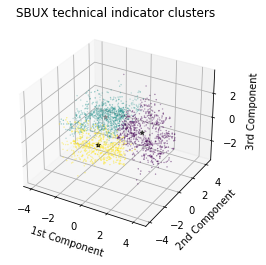

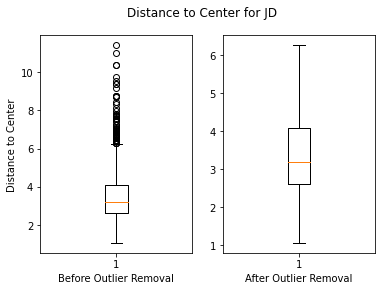

JD has 259 outliers out of 1783 points (14.53%)


,RSI,Ultimate,BandRadius,Chaikin,NATR,SMA_5,SMA_20,SMA_100,SAR,Williams%R,APO,ROC_5,ROC_20,ROC_100,ClusterCoverage%
0,60.697375,50.891057,0.025957,-6.742942e+05,3.095457,0.995335,0.965900,0.912616,1.402210,-35.315128,0.029216,0.013655,0.087355,0.134848,0.246719
1,52.251812,52.881637,0.041706,1.049807e+06,3.998384,0.984447,0.984520,1.046714,0.955055,-34.707303,-0.012234,0.033736,0.000750,-0.053712,0.179790
2,40.450062,44.093405,0.038915,-3.833975e+06,4.089210,1.012523,1.043459,1.081434,0.754984,-73.852432,-0.020609,-0.028237,-0.066364,-0.036504,0.235564
3,62.635719,58.913534,0.037856,6.378158e+06,3.429079,0.984923,0.952138,0.878551,0.568010,-21.628836,0.020551,0.038476,0.084120,0.261397,0.169948
4,51.990440,50.298802,0.034158,1.308374e+06,3.476273,1.010753,1.005650,0.913450,0.481522,-57.613697,0.013950,-0.018759,0.024986,0.261848,0.167979


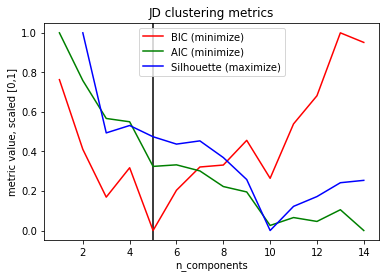

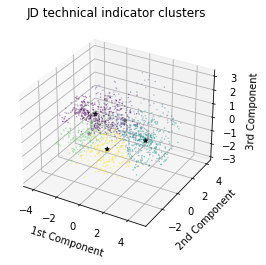

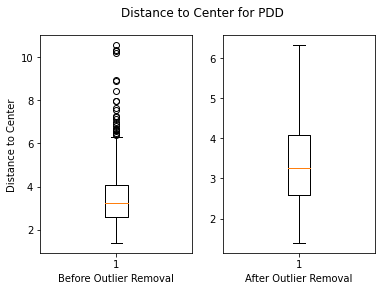

PDD has 95 outliers out of 731 points (13.0%)


,RSI,Ultimate,BandRadius,Chaikin,NATR,SMA_5,SMA_20,SMA_100,SAR,Williams%R,APO,ROC_5,ROC_20,ROC_100,ClusterCoverage%
0,54.682137,53.736482,0.045933,1.594510e+06,4.828449,0.985142,0.966717,0.997805,0.514797,-34.830329,0.003777,0.038364,0.057119,0.079578,0.396226
1,60.673884,49.229344,0.060064,-2.747152e+05,5.685386,0.997600,0.944253,0.699456,0.202658,-39.983964,0.059610,0.016109,0.190126,0.986253,0.284591
2,41.553159,44.852463,0.050256,-2.381765e+06,5.625339,1.016802,1.060425,1.105587,0.375115,-72.419717,-0.030897,-0.035514,-0.095861,0.086988,0.319182


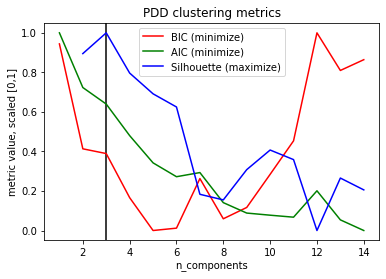

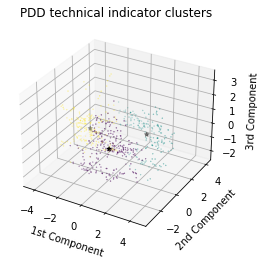

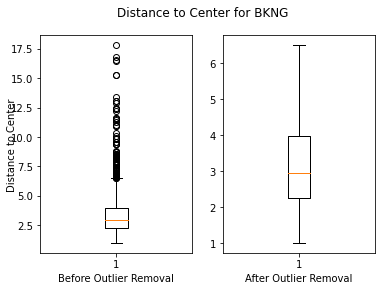

BKNG has 307 outliers out of 2417 points (12.7%)


,RSI,Ultimate,BandRadius,Chaikin,NATR,SMA_5,SMA_20,SMA_100,SAR,Williams%R,APO,ROC_5,ROC_20,ROC_100,ClusterCoverage%
0,52.842892,55.635303,0.024747,154860.322628,2.264420,0.986654,0.990814,1.009543,0.280942,-28.111702,-0.015800,0.027817,-0.016768,-0.009174,0.036493
1,64.106621,54.704546,0.021275,94820.474325,2.008389,0.998975,0.967944,0.888195,0.413824,-30.545714,0.031971,0.007403,0.086249,0.227216,0.093365
2,35.089240,36.063269,0.024725,-412844.912118,2.348535,1.019861,1.051087,1.037333,0.291420,-95.967238,-0.010289,-0.046218,-0.058158,-0.009393,0.018957
3,60.075535,55.950680,0.022086,140453.479602,2.080695,0.991961,0.975174,0.940937,0.308142,-25.703852,0.010678,0.019877,0.042923,0.117853,0.112796
4,53.112901,50.408641,0.021635,-21880.049412,2.096541,0.999167,0.996500,0.971728,0.217425,-43.761516,0.003614,0.002449,0.012619,0.067158,0.238863


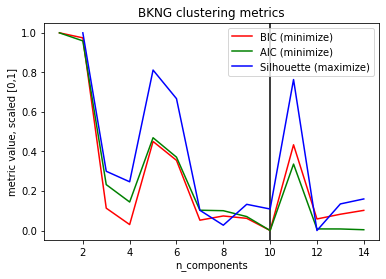

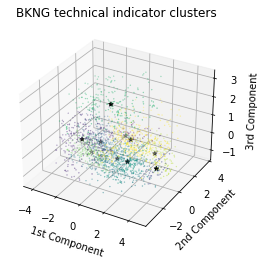

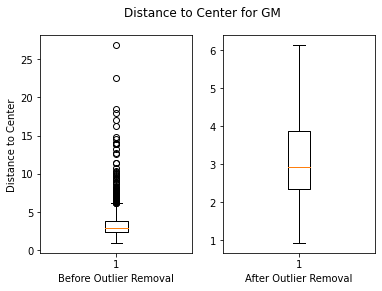

GM has 302 outliers out of 2417 points (12.49%)


,RSI,Ultimate,BandRadius,Chaikin,NATR,SMA_5,SMA_20,SMA_100,SAR,Williams%R,APO,ROC_5,ROC_20,ROC_100,ClusterCoverage%
0,55.291205,0.138076,0.023160,-1.027490e+09,24.942312,0.996283,0.985572,0.963899,0.764434,-277.202077,0.008407,0.010231,0.031079,0.075757,0.500236
1,40.753068,2.900946,0.025953,-5.883035e+08,16.331648,1.008038,1.031490,1.044739,0.668616,-207.425512,-0.016827,-0.018590,-0.051305,-0.009063,0.270449
2,55.655605,16.171495,0.026180,-1.444374e+08,6.441306,0.996199,0.985292,0.961349,0.576527,-80.474074,0.008798,0.010133,0.032515,0.084729,0.229314


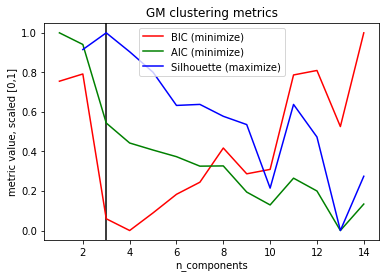

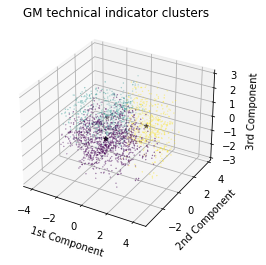

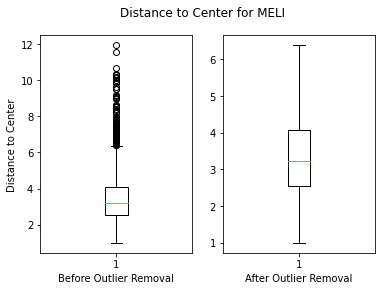

MELI has 322 outliers out of 2417 points (13.32%)


,RSI,Ultimate,BandRadius,Chaikin,NATR,SMA_5,SMA_20,SMA_100,SAR,Williams%R,APO,ROC_5,ROC_20,ROC_100,ClusterCoverage%
0,38.532551,40.619887,0.042959,-1.935130e+05,4.181173,1.014404,1.055538,1.052964,0.159211,-77.426414,-0.032663,-0.030475,-0.098369,0.093130,0.120286
1,62.835910,33.996811,0.027703,-1.190679e+06,3.410559,0.991671,0.956003,0.885230,0.535632,-37.712288,0.032129,0.022670,0.106109,0.221509,0.119332
2,45.419467,17.256720,0.031435,-1.911246e+06,3.930238,1.011151,1.030465,1.017761,0.659038,-80.111359,-0.009498,-0.024389,-0.036907,0.057224,0.238186
3,50.258631,35.346485,0.037740,-1.035350e+06,4.069531,0.987603,0.994974,1.056854,0.496887,-47.651577,-0.018344,0.026753,-0.016901,-0.055962,0.063007
4,65.642324,50.527827,0.030983,-9.151628e+04,3.277719,0.990773,0.945405,0.833685,0.231210,-25.088722,0.040375,0.027395,0.131554,0.348815,0.181384


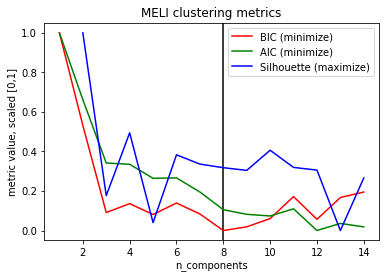

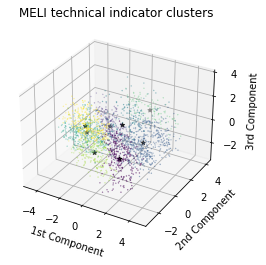

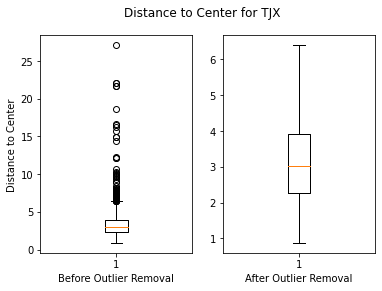

TJX has 260 outliers out of 2417 points (10.76%)


,RSI,Ultimate,BandRadius,Chaikin,NATR,SMA_5,SMA_20,SMA_100,SAR,Williams%R,APO,ROC_5,ROC_20,ROC_100,ClusterCoverage%
0,61.679294,6.895277,0.017584,-1.500863e+08,6.258642,0.996497,0.978619,0.918964,0.355361,-111.556212,0.016662,0.009604,0.049230,0.166051,0.073250
1,54.044792,1.749692,0.017501,-2.680797e+08,9.026183,0.999840,0.994794,0.963121,0.478161,-177.446279,0.005808,0.001372,0.016067,0.089375,0.070932
2,59.405991,11.894126,0.020732,-4.192326e+07,3.470127,0.992403,0.979631,0.950460,0.239245,-50.514449,0.008293,0.017244,0.034096,0.090793,0.158554
3,55.601822,-3.418916,0.014866,-4.287386e+08,12.997168,1.000028,0.992298,0.952650,0.648412,-250.324766,0.008873,0.001211,0.023494,0.116478,0.153454
4,44.893082,-0.856107,0.019325,-3.566060e+08,10.946143,0.998993,1.010634,1.034429,0.568188,-217.410640,-0.012118,0.001067,-0.028826,-0.051234,0.073713


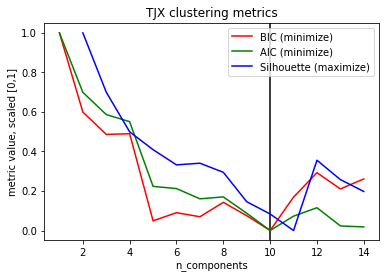

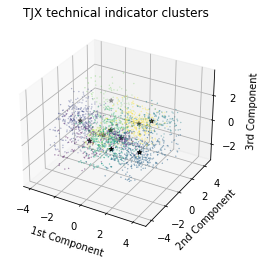

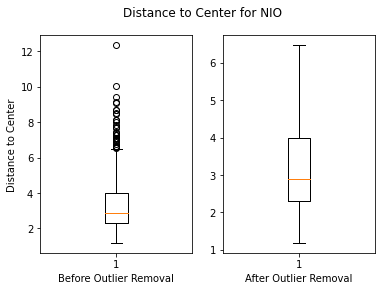

NIO has 109 outliers out of 698 points (15.62%)


,RSI,Ultimate,BandRadius,Chaikin,NATR,SMA_5,SMA_20,SMA_100,SAR,Williams%R,APO,ROC_5,ROC_20,ROC_100,ClusterCoverage%
0,59.944186,55.640014,0.067368,4.108952e+07,6.862517,1.001534,0.944219,0.609725,-0.411632,-40.129391,0.073579,0.011513,0.247779,2.184580,0.149406
1,36.973585,40.448534,0.081139,-2.892008e+07,9.432596,1.037195,1.105365,1.343199,4.279636,-81.228509,-0.057380,-0.072747,-0.147750,-0.388142,0.079796
2,69.731963,61.482178,0.091392,5.107802e+07,7.735596,0.953469,0.820839,0.667356,2.331539,-12.249027,0.105961,0.129175,0.469922,1.533475,0.044143
3,55.375855,52.344631,0.087304,1.107292e+07,8.308304,0.978753,0.933286,1.056832,3.759632,-38.261229,0.022493,0.065011,0.188989,0.256991,0.173175
4,59.089116,54.156852,0.088978,4.934918e+07,9.398349,1.037950,0.972760,0.428930,0.397937,-56.018865,0.113677,-0.057370,0.329219,3.039039,0.056027


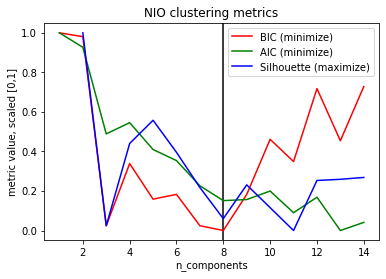

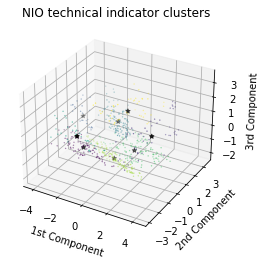

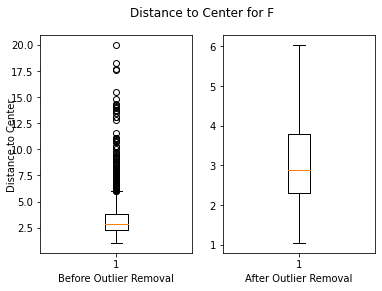

F has 367 outliers out of 2417 points (15.18%)


,RSI,Ultimate,BandRadius,Chaikin,NATR,SMA_5,SMA_20,SMA_100,SAR,Williams%R,APO,ROC_5,ROC_20,ROC_100,ClusterCoverage%
0,51.629021,21.033168,0.026037,-2.836877e+07,0.568227,1.002434,1.001572,0.959189,1.843558,-26.427929,0.004519,-0.003893,0.011589,0.113495,0.123415
1,53.740381,3.844766,0.021723,-2.760917e+09,26.990833,0.995620,0.990224,0.986565,1.143556,-306.126200,0.002630,0.010328,0.016837,0.034510,0.267317
2,36.453644,-1.001194,0.023506,-2.678112e+09,27.212998,1.007398,1.037073,1.086233,1.203260,-321.413115,-0.024741,-0.018145,-0.069888,-0.090244,0.152683
3,48.976866,-3.321572,0.019815,-4.040326e+09,39.274243,1.003264,1.004991,1.000904,0.823492,-460.603734,0.000307,-0.005762,-0.001413,0.026499,0.234634
4,50.769167,15.042876,0.025192,-7.531279e+08,7.819543,0.999003,1.000714,0.986586,1.662981,-96.808324,-0.001099,0.002517,0.002810,0.055643,0.109756


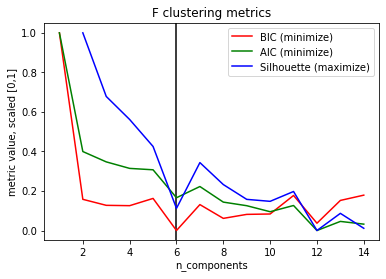

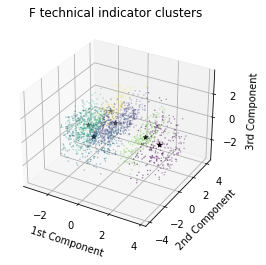

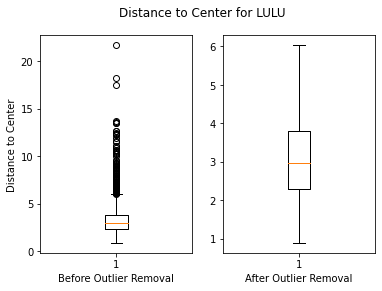

LULU has 369 outliers out of 2417 points (15.27%)


,RSI,Ultimate,BandRadius,Chaikin,NATR,SMA_5,SMA_20,SMA_100,SAR,Williams%R,APO,ROC_5,ROC_20,ROC_100,ClusterCoverage%
0,64.756162,60.523678,0.028967,1.135718e+06,2.820227,0.980474,0.947124,0.926628,0.742139,-9.716448,0.018109,0.046032,0.085469,0.131270,0.092773
1,54.510942,50.738865,0.026166,9.678281e+04,2.717910,1.003460,0.993620,0.933146,0.729124,-47.877739,0.014153,-0.004746,0.035792,0.175440,0.232422
2,48.233161,52.312326,0.033883,3.742865e+05,3.128375,0.993710,1.007531,1.003063,0.364622,-45.374542,-0.020124,0.013694,-0.038557,0.107938,0.134766
3,61.071521,56.944497,0.027539,7.173187e+05,2.875663,0.987526,0.956566,0.979859,1.258365,-21.300274,0.020555,0.030505,0.081709,-0.007445,0.133789
4,65.054859,58.178802,0.026183,8.932608e+05,2.543851,0.989768,0.959690,0.841971,0.246050,-20.408578,0.024963,0.026547,0.085701,0.348865,0.169434


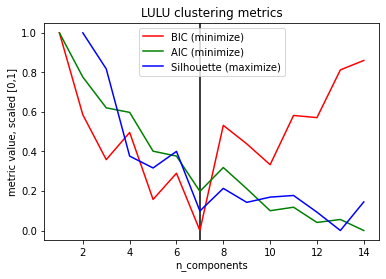

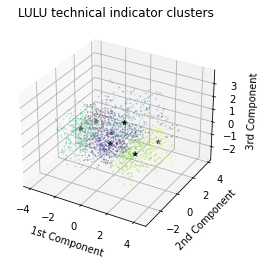

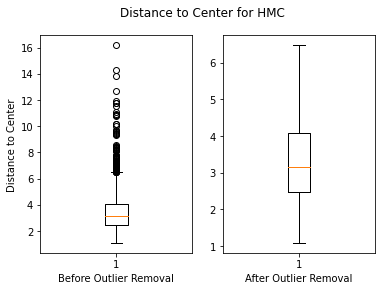

HMC has 293 outliers out of 2417 points (12.12%)


,RSI,Ultimate,BandRadius,Chaikin,NATR,SMA_5,SMA_20,SMA_100,SAR,Williams%R,APO,ROC_5,ROC_20,ROC_100,ClusterCoverage%
0,40.835439,26.906201,0.024042,-1.297561e+06,1.775040,1.010856,1.028086,1.004560,0.769188,-87.460537,-0.004086,-0.025177,-0.028810,0.048654,0.047081
1,62.140018,59.099484,0.013593,3.475482e+05,1.288848,1.000310,0.975454,0.924097,1.358831,-28.597620,0.023606,0.004280,0.061911,0.120844,0.108286
2,43.801023,45.914577,0.022199,-1.855456e+05,1.690210,0.995815,1.011376,1.060106,1.190017,-51.840464,-0.018835,0.006075,-0.038465,-0.085864,0.091337
3,57.290747,40.817812,0.022129,-1.047427e+06,1.714584,0.992736,0.983749,0.955163,0.673330,-33.935480,0.006013,0.014941,0.026525,0.084759,0.111111
4,44.682190,44.679455,0.018293,-5.925861e+04,1.490623,1.009984,1.017357,1.006880,1.333271,-71.612727,0.000891,-0.020361,-0.011724,0.020383,0.166667


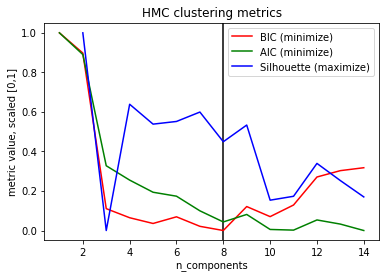

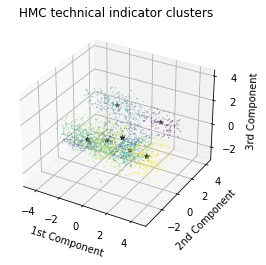

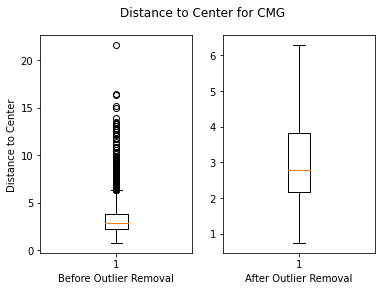

CMG has 351 outliers out of 2417 points (14.52%)


,RSI,Ultimate,BandRadius,Chaikin,NATR,SMA_5,SMA_20,SMA_100,SAR,Williams%R,APO,ROC_5,ROC_20,ROC_100,ClusterCoverage%
0,43.265155,43.324463,0.025596,-256674.449597,2.455366,1.008633,1.027540,1.009334,0.432492,-70.126283,-0.010594,-0.019147,-0.038155,0.075554,0.334463
1,61.236566,56.354295,0.023317,191903.859478,2.220487,0.991469,0.971696,0.901534,0.359192,-26.280672,0.014415,0.021384,0.054582,0.228480,0.431268
2,56.440670,52.523594,0.023790,83908.096619,2.527884,0.996897,0.979107,0.993103,0.870059,-36.291671,0.014516,0.009680,0.049701,-0.004406,0.234269


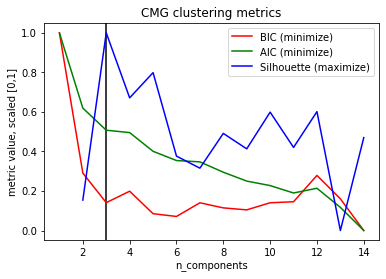

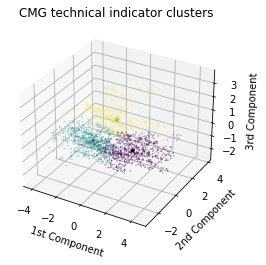

In [46]:
print("Clustering stocks using GMM")
numClusters = []
for i in range(len(tickers)):

    # read in data from csv
    data = pd.read_csv(f'./data/{tickers[i]}.csv')

    # generate matrix with technical indicators (features) as columns
    features = data.to_numpy()[:, 6:]

    # normalize each feature
    scaler = StandardScaler()
    X = scaler.fit_transform(features)


    # Remove outliers
    center = np.mean(X, axis=0)
    
    distToCenter = np.linalg.norm(X-center, axis=1)

    #box plot of distance to center
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f'Distance to Center for {tickers[i]}')
    ax1.boxplot(distToCenter)
    plt.setp(ax1, xlabel='Before Outlier Removal')
    plt.setp(ax2, xlabel='After Outlier Removal')
    ax2.boxplot(distToCenter, showfliers=False)
    fig.text(0.06, 0.5, 'Distance to Center', ha='center', va='center', rotation='vertical')
    plt.show()



    # Calculate IQR
    q75, q25 = np.percentile(distToCenter, [75 ,25])
    
    iqr = q75 - q25

    # Calculate outlier cutoff and remove outliers
    nonOutlierIndices = np.argwhere((distToCenter < q75 + 0.5 * iqr) & (distToCenter > q25 - 1 * iqr)).reshape(-1)
    outlierPercentage = 100 * (len(X) - len(nonOutlierIndices)) / float(len(X))
    print(f'{tickers[i]} has {len(X) - len(nonOutlierIndices)} outliers out of {len(X)} points ({round(outlierPercentage, 2)}%)')
    X = X[nonOutlierIndices]

    


    # PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=3)
    X = pca.fit_transform(X)
    
    # GMM
    n_components = np.arange(1, features.shape[1]+1)
    gmms = [GaussianMixture(n_components=k, covariance_type='full').fit(X) for k in n_components]

    
    # Calculate metrics
    silhouettes = np.array([metrics.silhouette_score(X, gmms[k-1].predict(X)) for k in n_components[1:]])
    bics = np.array([gmm.bic(X) for gmm in gmms])
    aics = np.array([gmm.aic(X) for gmm in gmms])
    
    minidx = min(np.argmin(bics), np.argmin(aics))
    argmaxSil = np.argmax(silhouettes)
    if argmaxSil > 0 and silhouettes[argmaxSil - 1] < silhouettes[argmaxSil]:
        # enforce local maximum (peak) for silhouette
        minidx = min(minidx, argmaxSil + 1)
        
    numClusters.append(minidx + 1)
    
    centroids = gmms[minidx].means_

    # descale centroids
    centroids_descaled = scaler.inverse_transform(pca.inverse_transform(centroids))

    # create df for centroids
    centroids_df = pd.DataFrame(centroids_descaled, columns=data.columns[6:])
    centroids_df['ClusterCoverage%'] = [pair[1] / X.shape[0] for pair in np.asarray(np.unique(gmms[minidx].predict(X), return_counts=True)).T]
    display(centroids_df.head())
    if not os.path.exists("centroids"):
        os.mkdir("centroids")
    centroids_df.to_csv(f'./centroids/{tickers[i]}_centroids.csv')


    # plot the results
    plt = reload(plt)
    fig = plt.figure()
    plt.title(f"{tickers[i]} clustering metrics")
    plt.axvline(x=minidx + 1, color='black')
    plt.plot(n_components, minmax_scale(bics), label='BIC (minimize)', color='r')
    plt.plot(n_components, minmax_scale(aics), label='AIC (minimize)', color='g')
    plt.plot(n_components[1:], minmax_scale(silhouettes), label='Silhouette (maximize)', color='b')
    plt.legend(loc='best')
    plt.xlabel('n_components')
    plt.ylabel('metric value, scaled [0,1]')

    plt.show()

    plt = reload(plt)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], s=0.1, c=gmms[minidx].predict(X), cmap='viridis')
    ax.scatter3D(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='*', c='black')
    ax.set_xlabel("1st Component")
    ax.set_ylabel("2nd Component")
    ax.set_zlabel("3rd Component")
    plt.title(f"{tickers[i]} technical indicator clusters")

    plt.show()

    # plt.plot(n_components[1:], silhouette_avg, label='SC')
    # plt.legend(loc='best')
    # plt.xlabel('n_components')
    # plt.ylabel('Sillhouette Score')
    # plt.show()


number of clusters (raw) [5, 5, 6, 3, 12, 3, 12, 3, 3, 5, 3, 10, 3, 8, 10, 8, 6, 7, 8, 3]
mean: 6.15 , rounds to 6 clusters


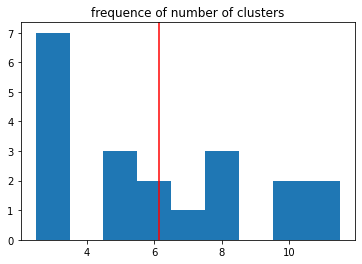

In [47]:
%matplotlib inline

print('number of clusters (raw)', numClusters)
print('mean:', np.mean(numClusters), ', rounds to', int(np.mean(numClusters)), 'clusters')

fig = plt.figure()
plt.hist(numClusters, align='left', bins=np.max(numClusters) - np.min(numClusters))
plt.axvline(x=np.mean(numClusters), c='red')
plt.xlabel="num clusters"
plt.ylabel='freq'
plt.title('frequence of number of clusters')
plt.show()